In [ ]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  from getpass import getpass
  user = getpass('GitHub user')
  password = getpass('GitHub password')
  import os
  os.environ['GITHUB_AUTH'] = user + ':' + password
  !git clone https://$GITHUB_AUTH@github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

In [1]:
#@title Setup environment and Colab general variables { display-mode: "form" }
%%capture
%run conda_colab.ipynb

In [2]:
#@title (COLAB ONLY) Code for setting the environment, installation of packages { display-mode: "form" }
%%capture
if IN_COLAB:
  %env PYTHONPATH=
  !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
  !chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
  !./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
  !conda install --channel defaults conda python=3.6 --yes -q
  !conda update --channel defaults --all --yes -q
  import sys
  sys.path.insert(0, "/usr/local/lib/python3.6/site-packages")

  # !pip install fastai pydicom kornia fastcore==1.0.9 --upgrade --quiet
  !conda config --add channels conda-forge
  !conda install -c fastai -c pytorch fastai fastcore=1.0.9 pydicom gdcm kornia scikit-image scikit-learn pandas numpy ipykernel xlrd --yes -q

In [ ]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  from getpass import getpass
  user = getpass('GitHub user')
  password = getpass('GitHub password')
  import os
  os.environ['GITHUB_AUTH'] = user + ':' + password
  !git clone https://$GITHUB_AUTH@github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

In [2]:
if IN_COLAB:
  PATH_DRIVER = '/content/gdrive/My Drive/'
  DATA_FOLDER = 'Dataset/'
else:
  PATH_DRIVER = ''
  DATA_FOLDER = 'data/'

In [3]:
import pandas as pd
import numpy as np
import sklearn

import os
import gc

import matplotlib.pyplot as plt

from fastai.basics import *
from fastai.medical.imaging import *

In [4]:
PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
raw_folder = PATH_PREFIX + 'DICOMS'
organize_folder = PATH_PREFIX + 'pending_classification'
preprocess_folder = PATH_PREFIX + 'preprocess'

BATCH_SIZE = 32

In [5]:
from utils import concat_templates

# df = concat_templates(organize_folder, excel=True)
# df.to_excel(
#     os.path.join(PATH_PREFIX, 'all.xlsx'),
#     index=False
# )
df = pd.read_excel(os.path.join(PATH_PREFIX, 'all.xlsx'), dtype={'ID':'string','Target':'string'})

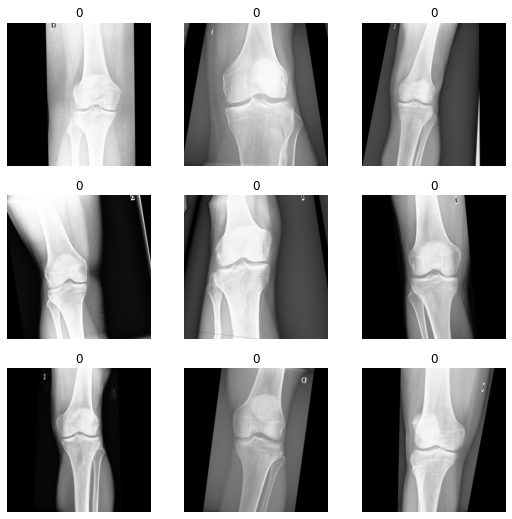

In [6]:
from fastai.basics import *
from fastai.callback import *
from fastai.data.block import *
from fastai.data.transforms import *
from fastai.medical.imaging import *
from fastai.vision.data import *
from fastai.vision.augment import *
from fastai.vision.all import *
from fastai.vision.widgets import *

label_data = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('ID', pref=preprocess_folder+'/', suff='.png'), 
    get_y=ColReader('Target'),
    splitter=RandomSplitter(),
    item_tfms=Resize(512),
    batch_tfms=[*aug_transforms()],
).dataloaders(df[['ID','Target']][df['Target'].notnull()], bs=BATCH_SIZE, num_workers=0)

label_data.show_batch()

In [12]:
import torch

def focal_loss(input, target, reduction='mean', beta=0.5, gamma=2., eps=1e-7, **kwargs):
    n = input.size(0)
    iflat = torch.sigmoid(input).view(n, -1).clamp(eps, 1-eps)
    tflat = target.view(n, -1)
    focal = -(beta*tflat*(1-iflat).pow(gamma)*iflat.log()+
             (1-beta)*(1-tflat)*iflat.pow(gamma)*(1-iflat).log()).mean(-1)
    if torch.isnan(focal.mean()) or torch.isinf(focal.mean()):
        pdb.set_trace()
    if reduction == 'mean':
        return focal.mean()
    elif reduction == 'sum':
        return focal.sum()
    else:
        return focal

class FocalLoss(nn.Module):
    def __init__(self, beta=0.5, gamma=2., reduction='mean'):
        super().__init__()
        self.beta = beta
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input, target, **kwargs):
        return focal_loss(input, target, beta=self.beta, gamma=self.gamma, reduction=self.reduction, **kwargs)

In [13]:
# Define the callbacks that will be used during training
callback_fns = [
        MixUp(),
        # partial(OverSamplingCallback),
        # ShowGraph
    ]
roc_auc = RocAuc()
f1_score = F1ScoreMulti(average='macro')
precision = PrecisionMulti(average='macro')
recall = RecallMulti(average='macro')
learn = cnn_learner(
    label_data,
    resnet18,
    loss_func=FocalLoss(),
    metrics=[
        accuracy_multi,
        # roc_auc, # Not able if in some step/epoch there is only one class
        f1_score,
        precision,
        recall
    ],
    callback_fns=callback_fns
)

# Regularization by using float precision of 16 bits
# This helps to not overfit because is more difficult to "memorize" images, but enough to learn
learn = learn.to_fp16()

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=1.3182567499825382e-06)

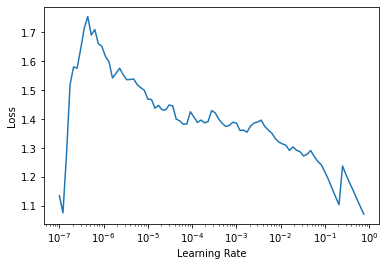

In [34]:
learn.lr_find()

In [17]:
learn.fine_tune(10, 0.07, freeze_epochs=3)

epoch     train_loss  valid_loss  accuracy_multi  f1_score  precision_score  recall_score  time    
0         0.579060    0.713597    0.500000        0.000000  0.000000         0.000000      00:19     
1         0.428448    0.870778    0.437500        0.384615  0.480769         0.320513      00:19     
2         0.313913    0.184434    0.937500        0.493671  0.487500         0.500000      00:19     
epoch     train_loss  valid_loss  accuracy_multi  f1_score  precision_score  recall_score  time    
0         0.062009    1.560991    0.200000        0.215278  0.514286         0.615385      00:22     
1         0.054819    7.531586    0.025000        0.024390  0.012500         0.500000      00:20     
2         0.069965    3.166458    0.600000        0.170213  0.500000         0.102564      00:21     
3         0.081687    0.200378    0.975000        0.493671  0.487500         0.500000      00:20     
4         0.087161    0.200378    0.975000        0.493671  0.487500         0.500000 

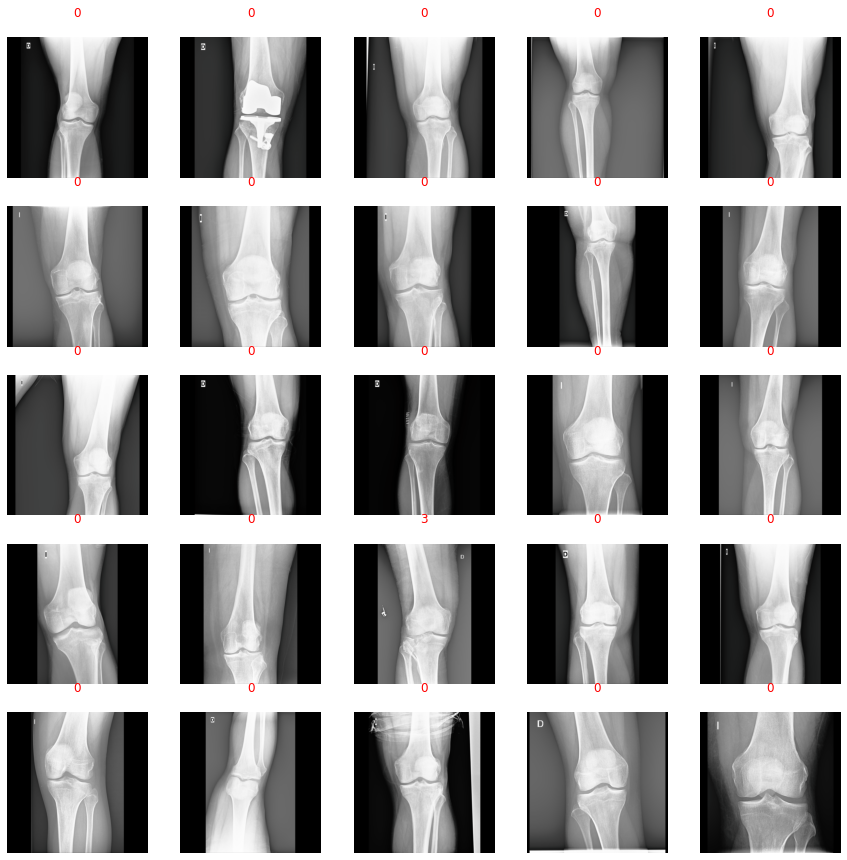

In [18]:
learn.show_results(max_n=25)

,target,predicted,probabilities,loss
0,3,,"tensor([ 16.7031, -16.0781])",8.005125045776367
1,0,,"tensor([13.8438, -6.2305])",1.897737522682519e-09
2,0,,"tensor([24.2656, -8.7422])",1.0179376872671009e-12
3,0,,"tensor([ 18.8906, -10.0000])",2.3402158303657133e-14
4,0,,"tensor([ 10.1953, -10.7891])",1.5179992544000695e-14
5,0,,"tensor([ 12.8359, -10.2812])",1.0066532568457631e-14
6,0,,"tensor([ 20.2500, -10.3359])",8.533294513710099e-15
7,0,,"tensor([ 25.9531, -11.7500])",1.2242498058911424e-16
8,0,,"tensor([ 30.4062, -12.5156])",1.2436278352291772e-17
9,0,,"tensor([ 14.8672, -12.8516])",4.519038646838981e-18


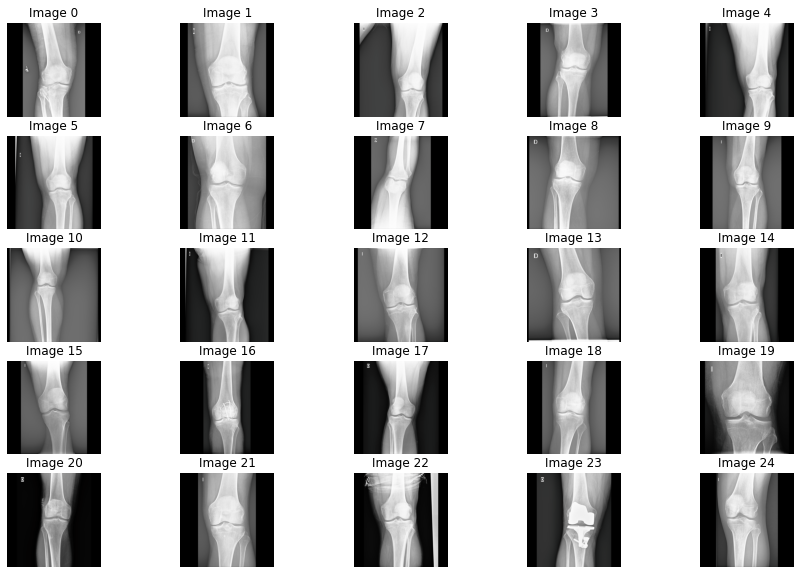

In [19]:
interp = Interpretation.from_learner(learn)
losses, idx = interp.top_losses()
interp.plot_top_losses(25, figsize=(15,10))